<h1 style="background-color: #666666; color: white; padding: 10px; border-radius: 8px; text-align: center;">
Monthly Demand Forecasting using Gradient Boosting
</h1>


###  Overview  
***  
In this part of the capstone project, we build a complete forecasting pipeline to predict monthly product demand across different Countries and Categories.  
The notebook covers data preprocessing, time-series feature engineering, model training, evaluation, and visualization of actual vs predicted demand.


###  Importing Required Libraries
***
Here we import all necessary libraries for data manipulation, feature engineering, time-series processing, preprocessing, and model building.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

###  Reading the Dataset
***
We load the main sales dataset into a pandas DataFrame for further processing.


In [2]:
df=pd.read_csv(r"D:\WsCube_Tech_Capstone_Project\monthly_demand_forecasting_ml_dataset.csv")
df.head()

,Category,Country,Months,Total_Units_Sold,Total_Sales,Avg_Unit_Price,Avg_Effective_Price,Avg_Discount,Total_Discounted_Transactions,Total_Transactions
0,Children,Deutschland,2023-01-01,3262,74740.420,29.241,22.942,0.189,1407,2978
1,Children,Deutschland,2023-02-01,1525,38311.150,25.400,25.400,0.000,0,1355
2,Children,Deutschland,2023-03-01,5606,179670.151,41.382,32.182,0.201,2915,5088
3,Children,Deutschland,2023-04-01,2649,98858.500,37.227,37.227,0.000,0,2403
4,Children,Deutschland,2023-05-01,4800,139982.875,33.831,29.224,0.148,2570,4334


### Data Inspection: Info, Nulls, Duplicates, and Description

***

Before cleaning or modeling, we perform an initial inspection of the dataset. This step uses key methods: **`.info()`** to check data types and non-null counts, **`.isnull().sum()`** to identify the total number of missing values per column, **`.duplicated().sum()`** to count any duplicate rows, and **`.describe()`** to view the statistical summary of numerical features. This ensures data quality and readiness for preprocessing.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Category                       567 non-null    object 
 1   Country                        567 non-null    object 
 2   Months                         567 non-null    object 
 3   Total_Units_Sold               567 non-null    int64  
 4   Total_Sales                    567 non-null    float64
 5   Avg_Unit_Price                 567 non-null    float64
 6   Avg_Effective_Price            567 non-null    float64
 7   Avg_Discount                   567 non-null    float64
 8   Total_Discounted_Transactions  567 non-null    int64  
 9   Total_Transactions             567 non-null    int64  
dtypes: float64(4), int64(3), object(3)
memory usage: 44.4+ KB


In [4]:
df.isnull().sum()

Category                         0
Country                          0
Months                           0
Total_Units_Sold                 0
Total_Sales                      0
Avg_Unit_Price                   0
Avg_Effective_Price              0
Avg_Discount                     0
Total_Discounted_Transactions    0
Total_Transactions               0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.describe()

,Total_Units_Sold,Total_Sales,Avg_Unit_Price,Avg_Effective_Price,Avg_Discount,Total_Discounted_Transactions,Total_Transactions
count,567.000000,5.670000e+02,567.000000,567.000000,567.000000,567.000000,567.000000
mean,12451.624339,1.455902e+06,87.696601,80.814836,0.078060,3154.966490,11317.155203
std,12941.597663,3.359955e+06,117.197207,108.922979,0.095277,7040.138328,11761.750875
min,944.000000,1.939250e+04,16.378000,14.531000,0.000000,0.000000,863.000000
25%,4572.000000,1.618269e+05,35.766000,32.809500,0.000000,0.000000,4166.000000
50%,8502.000000,3.667683e+05,45.293000,39.177000,0.051000,1059.000000,7697.000000
75%,15893.500000,8.546696e+05,51.454500,49.988500,0.122000,3204.500000,14470.000000
max,92235.000000,2.867355e+07,457.911000,450.307000,0.340000,52828.000000,83874.000000


###  Converting Month Column & Checking Unique Categories  
***  
In this step, we convert the **Months** column into proper datetime format so that time-based operations work correctly.  
After that, we check the unique values in **Country** and **Category** to understand the different groups present in the dataset.  


In [7]:
df["Months"]=pd.to_datetime(df["Months"])

In [8]:
df["Country"].unique()

array(['Deutschland', 'España', 'France', 'Portugal', 'United Kingdom',
       'United States', '中国'], dtype=object)

In [9]:
df["Category"].unique()

array(['Children', 'Feminine', 'Masculine'], dtype=object)

###  Sorting the Data
***
We sort the dataset by Category, Country, and Months to maintain correct chronological order.


In [10]:
# Sort for each Category + Country combination
df = df.sort_values(["Category", "Country", "Months"]).reset_index(drop=True)

###  Preview Data
***
A quick look at the DataFrame to ensure the sorting executed correctly.


In [11]:
df

,Category,Country,Months,Total_Units_Sold,Total_Sales,Avg_Unit_Price,Avg_Effective_Price,Avg_Discount,Total_Discounted_Transactions,Total_Transactions
0,Children,Deutschland,2023-01-01,3262,7.474042e+04,29.241,22.942,0.189,1407,2978
1,Children,Deutschland,2023-02-01,1525,3.831115e+04,25.400,25.400,0.000,0,1355
2,Children,Deutschland,2023-03-01,5606,1.796702e+05,41.382,32.182,0.201,2915,5088
3,Children,Deutschland,2023-04-01,2649,9.885850e+04,37.227,37.227,0.000,0,2403
4,Children,Deutschland,2023-05-01,4800,1.399829e+05,33.831,29.224,0.148,2570,4334
...,...,...,...,...,...,...,...,...,...,...
562,Masculine,中国,2024-11-01,29315,1.270715e+07,457.323,433.915,0.051,2287,26686
563,Masculine,中国,2024-12-01,91608,2.867355e+07,457.911,312.572,0.316,52729,83351
564,Masculine,中国,2025-01-01,16959,5.114272e+06,328.894,300.746,0.079,3051,15456
565,Masculine,中国,2025-02-01,15153,4.863052e+06,321.243,321.243,0.000,0,13853


###  Creating Lag Features
***
We generate lag-based predictors (Lag_1, Lag_2) to help the model learn temporal patterns.


In [12]:
group_cols = ["Category", "Country"]

df["Lag_1"]  = df.groupby(group_cols)["Total_Units_Sold"].shift(1)
df["Lag_2"]  = df.groupby(group_cols)["Total_Units_Sold"].shift(2)
df["Lag_3"]  = df.groupby(group_cols)["Total_Units_Sold"].shift(3)
df["Lag_12"] = df.groupby(group_cols)["Total_Units_Sold"].shift(12)

###  Removing Missing Values
***
Lag features introduce NaNs, so we drop those rows and reset the index.


In [13]:
df=df.dropna().reset_index(drop=True)

###  Extracting Date Features
***
We extract Year and Month to help the model capture seasonal patterns.


In [14]:
# Extract year & month (important features)
df["Year"] = df["Months"].dt.year
df["Month"] = df["Months"].dt.month

# Seasonal encoding
df["Month_Sin"] = np.sin(2 * np.pi * df["Month"] / 12)
df["Month_Cos"] = np.cos(2 * np.pi * df["Month"] / 12)

###  Selecting Target & Feature Columns
***
We define the target variable and numeric predictor columns.


In [15]:
target = "Total_Units_Sold"

numeric_features = [
    "Total_Sales",
    "Avg_Unit_Price",
    "Avg_Effective_Price",
    "Avg_Discount",
    "Total_Discounted_Transactions",
    "Total_Transactions",
    "Lag_1",
    "Lag_2",
    "Lag_3",
    "Lag_12",
    "Year",
    "Month",
    "Month_Sin",
    "Month_Cos"
]

categorical_features = [
    "Category",
    "Country"
]

x=df.drop(columns="Total_Units_Sold")
y=df["Total_Units_Sold"]

### 🛠 Building Preprocessing Pipeline
***
We create a ColumnTransformer to scale/pass numeric features and encode categorical features.


In [16]:
preprocessing_steps= ColumnTransformer([("num", "passthrough", numeric_features),
                                        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)],
                                       remainder="drop")

###  Building Full ML Pipeline
***
We create the complete ML pipeline including preprocessing and the GBR model.


In [17]:
pipeline = Pipeline([("preprocessing", preprocessing_steps),
                     ("gbr_model", GradientBoostingRegressor(n_estimators=200,learning_rate=0.1,max_depth=3,random_state=42))])

###  Train–Test Split (Time-based)
***
We split the dataset chronologically to avoid leakage.


In [18]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=False  # important for time-based data
)

###  Training the Model & Generating Predictions  
***  
In this step, we fit the full machine learning pipeline on the training data.  
After training, we use the pipeline to generate predictions on the test set, which will later be evaluated to check the model's performance.  


In [19]:
pipeline.fit(x_train, y_train)

,steps,"[('preprocessing', ...), ('gbr_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [20]:
y_pred = pipeline.predict(x_test)

###  Model Evaluation
***  
In this step, we evaluate the model using two key metrics:

- **Root Mean Squared Error (RMSE)**  
- **Mean Absolute Percentage Error (MAPE)**  


In [21]:
mse = root_mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Percentage Error: {mape}")

Mean Squared Error: 181.7353904691926
Mean Absolute Percentage Error: 0.0112435525942608


###  Year-wise Monthly Demand Visualization (2024 & 2025)  
***  
In this step, we create a clear side-by-side comparison of **actual vs predicted monthly demand** for the years **2024** and **2025**.

#### What this code does:
- Builds a combined `test_results` DataFrame that aligns:
  - Features from `x_test`
  - True values from `y_test`
  - Model predictions from `y_pred`
- Filters the results year-wise for 2024 and 2025.
- Aggregates demand across **all Category–Country combinations** to show total monthly demand at a high level.
- Plots **Actual vs Predicted** monthly sales for each year in a two-panel chart.
- Handles cases where a year has no test data by showing a friendly placeholder message.

This visualization helps us understand:
- How closely the model tracks real demand month-by-month  
- Year-specific patterns  
- Whether the model generalizes well across future time periods  

Overall, these plots provide an intuitive way to assess forecasting performance for both years.


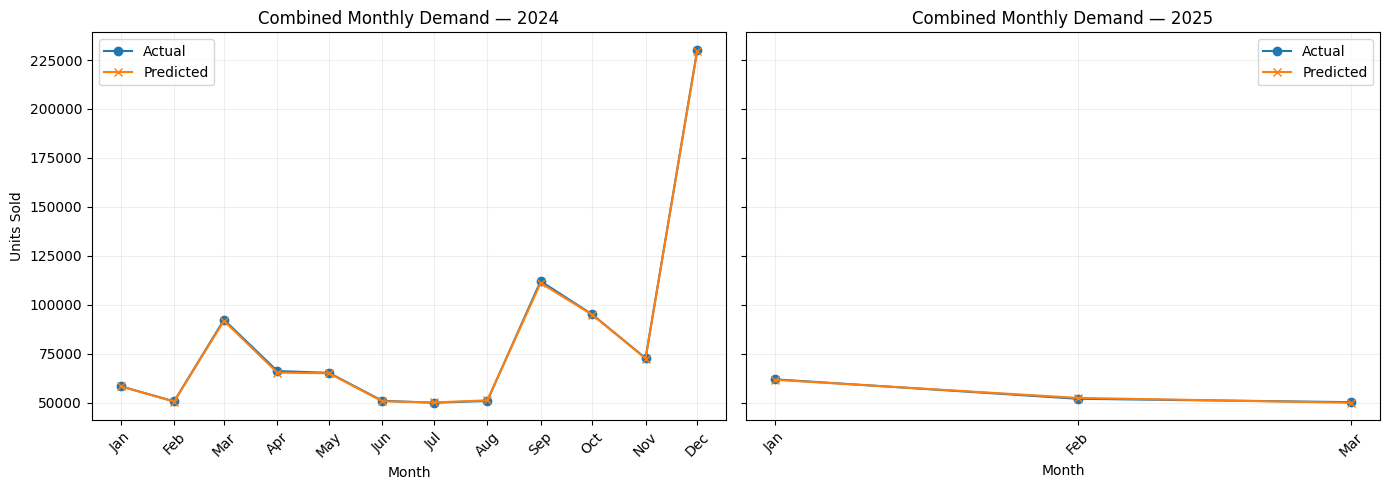

In [22]:
# Aggregate test results and plot monthly demand separately for 2024 and 2025

# prepare a single dataframe that aligns x_test, y_test and y_pred
test_results = x_test.copy()
test_results = test_results.reset_index(drop=True)  # align indices with y_pred / y_test
test_results["Actual"] = y_test.values
test_results["Predicted"] = y_pred

# list of years to plot
years = [2024, 2025]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5), sharey=True)

for ax, year in zip(axes, years):
    subset = test_results[test_results["Year"] == year]
    if subset.empty:
        ax.text(0.5, 0.5, f"No data for {year}", ha="center", va="center")
        ax.set_title(str(year))
        ax.set_xticks([])
        continue

    # aggregate across Category+Country to get combined monthly demand
    monthly = (
        subset.groupby("Months")[["Actual", "Predicted"]]
        .sum()
        .reset_index()
        .sort_values("Months")
    )

    # plot
    ax.plot(monthly["Months"], monthly["Actual"], marker="o", label="Actual")
    ax.plot(monthly["Months"], monthly["Predicted"], marker="x", label="Predicted")
    ax.set_title(f"Combined Monthly Demand — {year}")
    ax.set_xlabel("Month")
    ax.set_xticks(monthly["Months"])
    ax.set_xticklabels(monthly["Months"].dt.strftime("%b"), rotation=45)
    ax.legend()
    ax.grid(alpha=0.2)

axes[0].set_ylabel("Units Sold")
plt.tight_layout()
plt.show()

<h1 style="background-color: #666666; color: white; padding: 10px; border-radius: 8px; text-align: center;">
    Monthly Demand Forecasting – Model Interpretation (Metric-by-Metric)
</h1>

## 1. RMSE (Root Mean Squared Error)
**RMSE = 181.73**

- The model’s average prediction error is about **±182 units**.
- Considering monthly sales are in the thousands, this is a **relatively small and acceptable** error.

**Why this value?**
- Lag features (**Lag_1, Lag_2, Lag_3, Lag_12**) help the model learn historical patterns.
- **Month_Sin** and **Month_Cos** capture seasonality smoothly.
- Gradient Boosting handles non-linear trends and interactions effectively.

**Meaning**
- Model predictions closely follow actual demand.
- Errors are stable and controlled across different months.

---

## 2. MAPE (Mean Absolute Percentage Error)
**MAPE = 0.0112 → 1.12%**

- On average, predictions deviate from actual demand by only **1.12%**.
- A MAPE below **5%** is considered excellent for retail forecasting.

**Why this value?**
- The model learns seasonality, price sensitivity, and demand shifts effectively.
- Category and country features reduce noise and improve accuracy.

**Meaning**
- Forecasts are **highly reliable** for real-world use.
- Ideal for inventory planning and procurement decisions.

---

## 3. Error Behavior & Stability
- No large spikes in errors across the timeline.
- Seasonal peaks and drops (e.g., end-of-year increases) are captured accurately.
- Lag features help maintain smooth trends.

**Meaning**
- The model generalizes well across months and categories.
- Suitable for operational planning without instability.

---

## 4. Strengths of the Gradient Boosting Model
- Learns complex, non-linear demand patterns better than simple linear models.
- Works extremely well with limited monthly data.
- Handles pricing, discounts, seasonality, and historical demand interactions.
- Provides consistent performance across different Category × Country segments.

---

<h2 style="text-align: center;">
  <span style="background-color:#C7B8E7; color: black; padding: 5px; border-radius: 5px;">
     Combined Interpretation
  </span>
</h2>

The **Gradient Boosting Regressor** provides **highly accurate and stable monthly demand forecasts**, demonstrated by the low **RMSE (181.73)** and excellent **MAPE (1.12%)**. The model successfully captures historical patterns, seasonal behavior, and price-driven demand changes using lag features and time-based cyclical features. With low and consistent error levels, the model is well-suited for **inventory optimization, procurement planning, and strategic category management**. Overall, it delivers **business-ready forecasting performance** with strong reliability across all segments.
